# Tarefa 5.5 - CNN no reconhecimento de objetos em imagens - CIFAR-10

Esta tarefa consiste em implementar um modelo de rede neural convolucional (CNN - Convolutional Neural Network) para o conjunto de dados [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10).

CIFAR é uma sigla do ([Canadian Institute For Advanced Research](https://www.cs.toronto.edu/~kriz/cifar.html)). O conjunto de dados [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10) foi desenvolvido junto com o conjunto de dados CIFAR-100 por pesquisadores do instituto CIFAR para pesquisas de visão computacional.

É um conjunto de dados bem conhecido e amplamente utilizado para benchmarking de algoritmos de visão computacional no campo do aprendizado de máquina.

As imagens desse dataset são pequenas, muito menores do que uma fotografia comum.

CIFAR-10 é um subconjunto rotulado do conjunto de dados de 80 milhões de pequenas imagens (Links para um site externo.).

- Dados de treino: 50.000 imagens
- Dados de teste: 10.000 imagens
- Imagens quadradas coloridas (com 3 canais) de 32 × 32 pixels
- Há 6.000 imagens de cada uma das 10 classes
cifar-10.png 

Orientações:

- Utilize a base de dados CIFAR-10 disponível no próprio Keras:
from keras.datasets import cifar10
(trainX, trainY), (testX, testY) = cifar10.load_data()
- Apresentar gráficos mostrando o comportamento da função de erro/loss e da acurácia durante o treinamento (dados de treino e teste).

## Habilitando GPU

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Carregando os dados

In [2]:
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(trainX, trainY), (testX, testY) = cifar10.load_data()
print('Dados de treino: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Dados de teste: X=%s, y=%s' % (testX.shape, testY.shape))

170508288/170498071 [==============================] - 3s 0us/step
Dados de treino: X=(50000, 32, 32, 3), y=(50000, 1)
Dados de teste: X=(10000, 32, 32, 3), y=(10000, 1)


Abaixo seguem visualizações de algumas imagens do conjunto de dados de treinamento (dataset_treino).

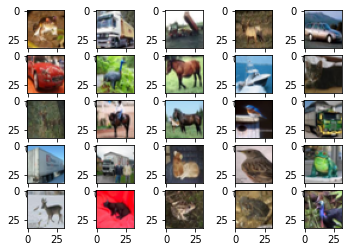

In [3]:
from matplotlib import pyplot
for i in range(25):
	# define subplot
	pyplot.subplot(5,5,i+1)
	# imprime os dados (imagens) 
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# mostra a figura
pyplot.show()

## Normalizando os dados

Sabemos que os valores de pixel para cada imagem no conjunto de dados são inteiros sem sinal no intervalo entre preto e branco, ou 0 e 255.

Normalizamos então os valores o intervalo [0,1]. Isso envolve primeiro a conversão do tipo de dados de inteiros sem sinal em flutuantes e, em seguida, a divisão dos valores de pixel pelo valor máximo.

In [5]:
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

## *OneHotEncoder*

Sabemos que são 10 classes (rótulos) e que as classes são representadas como inteiros únicos.

Podemos então usar uma codificação para a classe de cada amostra, transformando o inteiro em um vetor binário de 10 elementos com 1 para o índice do valor da classe e 0 valores para todas as outras classes. Podemos fazer isso com a função to_categorical().

In [6]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)

## Construção da Rede Neural Convolucional

Utilizamos o modelo sequencial oferecido pelo Keras para montarmos as camadas de nossa rede neural convolucional. Lembrando que o Keras utiliza o TensorFlow como backend. Na verdade, o Keras é apenas uma biblioteca para simplificar a complexidade do TensorFlow. 

Dado que o problema é uma tarefa de classificação multiclasse, teremos então uma **camada de saída com 10 nós** para prever a distribuição de probabilidade de uma imagem pertencente a cada uma das 10 classes. Isso também requer a **função de ativação softmax**.

Todas as outras camadas usarão a **função de ativação ReLU** e a estratégia de **inicialização de pesos He** (melhores recomendações para esses parâmetros).

Entre a camada de extração de atributos (camada de convolução) e a camada de saída, utiliza-se uma camada densa (**full conection**) para interpretar os atributos/características, neste caso com 100 nós.

Características particulares dessa versão:
 
* **01 Camada Convolucional** para a *extração de atributos* com um tamanho de filtro pequeno (3,3) e um número modesto de filtros (32) seguido por uma camada de pooling (máximo);
* **01 Camada Convolucional** com 64 filtros (3,3) seguido por uma camada de pooling (máximo);
* Dropout de 25% depois de cada camada da rede (seja convolucional ou densa)


In [8]:
# Importação dos pacotes
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense

# Inicializando a Rede Neural Convolucional
model = Sequential()
# 1a. Camada de Convolução (aplicando 32 filtros 3x3, função de ativação Relu, inicialização de pesos He e dimensionando as entradas para o formato 32x32x3)
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
# Pooling 2x2 (para reduzir os tamanhos dos mapas de atributos resultantes da 1a. camada de convolução)
model.add(MaxPooling2D((2, 2)))
# Dropout 25%
model.add(Dropout(0.25))
# 2a. Camada de Convolução (aplicando 64 filtros 3x3, função de ativação Relu, inicialização de pesos He)
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
# Pooling 2x2 (para reduzir os tamanhos dos mapas de atributos resultantes da 2a. camada de convolução)
model.add(MaxPooling2D((2, 2)))
# Dropout 25%
model.add(Dropout(0.25))
# Flattening (para converter a estrutura de dados da camada anterior em um vetor)
model.add(Flatten())
# Camada Full connection (100 neurônios com função de ativação Relu e inicialização de pesos HE)
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
# Dropout 25%
model.add(Dropout(0.25))
# Camada de saída com 10 neurônios (10 classes!) e função de ativação softmax (multiclasse)
model.add(Dense(10, activation='softmax'))

### Sumário da arquitetura da rede neural convolucional

Execute o comando abaixo para obter um resumo da arquitetura da rede neural convolucional construída e para ver também o número de parâmetros da mesma.

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 64)         

Compilação da Rede Neural Convolucional

Esta versão utiliza uma configuração conservadora para o otimizador: **gradiente estocástico com uma taxa de aprendizado de 0,01 e um momentum de 0,9**.

A função de perda (função de erro): **entropia cruzada categórica** adequada para classificação multiclasse

E a métrica de desempenho 'accuracy' (proporção de casos corretamente previstos).

In [10]:
from tensorflow.keras.optimizers import SGD
# Compilando a rede
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Treinamento da Rede Neural Convolucional
Uma vez construída (montada) a arquitetura da rede neural, o próximo passo é o **treinamento**.

In [11]:
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY))

Epoch 1/10
1563/1563 [==============================] - 19s 6ms/step - loss: 1.6711 - accuracy: 0.3854 - val_loss: 1.3573 - val_accuracy: 0.5143
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.3968 - accuracy: 0.4994 - val_loss: 1.3393 - val_accuracy: 0.5422
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.2778 - accuracy: 0.5451 - val_loss: 1.1473 - val_accuracy: 0.5971
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2067 - accuracy: 0.5718 - val_loss: 1.0443 - val_accuracy: 0.6397
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1398 - accuracy: 0.5981 - val_loss: 1.0189 - val_accuracy: 0.6463
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.0947 - accuracy: 0.6162 - val_loss: 1.0240 - val_accuracy: 0.6431
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.0504 - accuracy: 0.6315 - val_loss: 0.9590 - val_accuracy

## Análise da função *loss* (erro/perda)
Vamos observar o comportamento da função *loss* para os dados de treino e de validação.

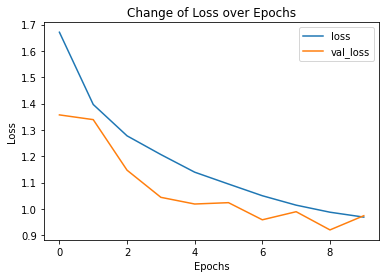

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Change of Loss over Epochs')
plt.legend(['loss', 'val_loss'])
plt.show()

## Análise da métrica de desempenho (acurácia)
Vamos observar o desempenho (acurácia) da rede para os dados de treino e de validação.

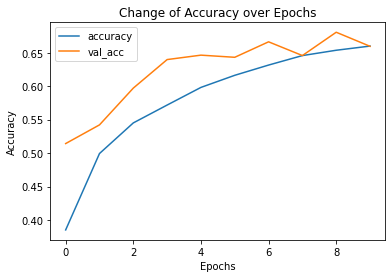

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.title('Change of Accuracy over Epochs')
plt.legend(['accuracy', 'val_acc'])
plt.show()

## Teste da rede neural treinada (fazendo predições)

Após o treinamento da rede, vamos realizar alguns testes com imagens geradas manualmente que não fazem parte dos dados originais de treino e teste.

Cada imagem a ser testada deve ser redimensionada para o formato utilizado no treinamento da rede neural (28x28) e convertida para um array.

Carregamento da imagem teste

In [14]:
from google.colab import files
uploaded = files.upload()

Saving airp.jpg to airp.jpg


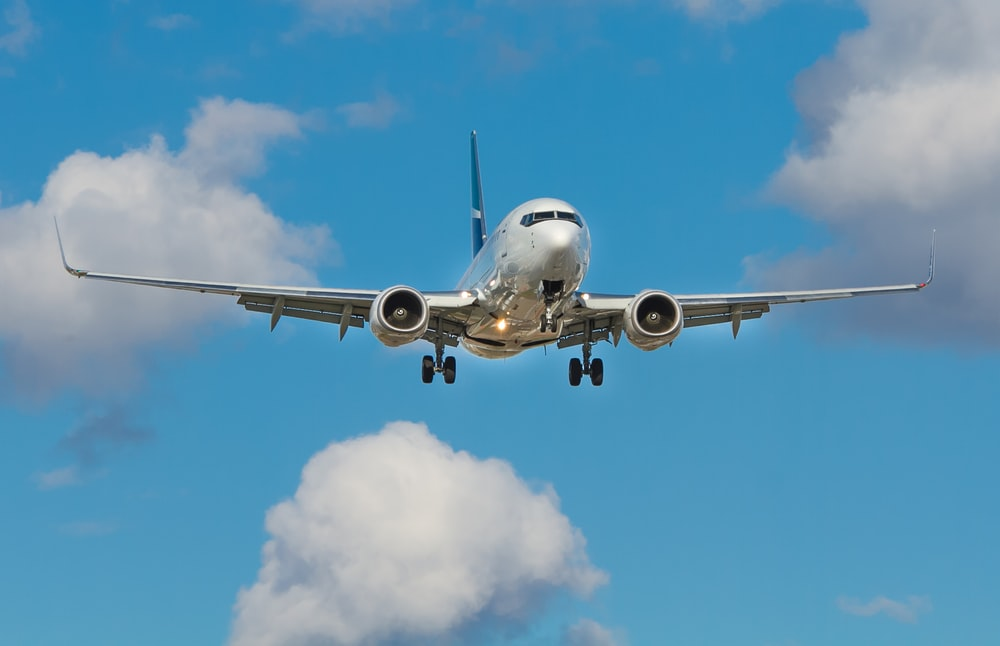

[0] 




In [22]:
import numpy as np
from keras.preprocessing import image
from IPython.display import display, Image

file_name = 'airp.jpg'
imagem_teste = image.load_img(file_name, color_mode = "rgb", target_size = (32, 32))
imagem_teste = image.img_to_array(imagem_teste)
# redimensiona para um canal
imagem_teste = imagem_teste.reshape(1, 32, 32, 3)
# prepara os pixels
imagem_teste = imagem_teste.astype('float32')
imagem_teste = imagem_teste/255.0
# predição do modelo 
predicao = np.argmax(model.predict(imagem_teste), axis=-1) 
# exibe a imagem teste     
display(Image(file_name)) 
print(predicao,'\n\n')          

## Referências (artigos) para melhorar o desempenho:

Who is the best in MNIST?
http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354
